In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data



In [14]:
# Data augmentation and normalization for training
# Just normalization for testidation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'transfer'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=40,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 19408
     Root location: transfer\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 8318
     Root location: transfer\test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 2
     Root location: transfer\validation
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolati

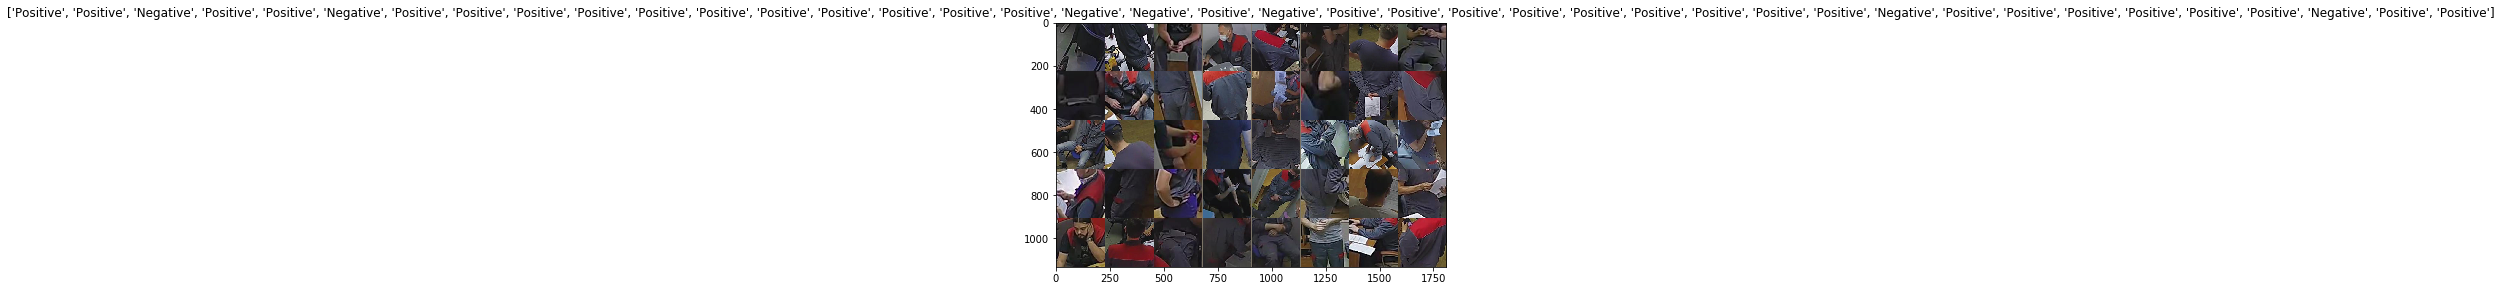

In [16]:
def imshow(inp, title=None):
    plt.figure(figsize=(7,7))
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1.0

    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))


        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc >= best_acc and epoch_loss < best_loss:
                print('*'*10)
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print('b_loss: {:.4f}, b_acc: {:.4f}'.format(best_loss, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, best loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model, best_model_wts

In [8]:
def visualize_model(model, data_set = 'test', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[data_set]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            smth, preds = torch.max(outputs, 1)
            o = 1
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    return o

In [17]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

#fully connected layer output
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

----------
Epoch 0/19
train Loss: 0.4047 Acc: 0.8173
test Loss: 0.2442 Acc: 0.9065
**********
loss: 0.2442, acc: 0.9065
----------
Epoch 1/19
train Loss: 0.2993 Acc: 0.8698
test Loss: 0.2048 Acc: 0.9152
**********
loss: 0.2048, acc: 0.9152
----------
Epoch 2/19
train Loss: 0.2602 Acc: 0.8906
test Loss: 0.1952 Acc: 0.9233
**********
loss: 0.1952, acc: 0.9233
----------
Epoch 3/19
train Loss: 0.2460 Acc: 0.8949
test Loss: 0.1851 Acc: 0.9276
**********
loss: 0.1851, acc: 0.9276
----------
Epoch 4/19
train Loss: 0.2243 Acc: 0.9094
test Loss: 0.1486 Acc: 0.9447
**********
loss: 0.1486, acc: 0.9447
----------
Epoch 5/19
train Loss: 0.2140 Acc: 0.9127
test Loss: 0.1547 Acc: 0.9416
loss: 0.1486, acc: 0.9447
----------
Epoch 6/19
train Loss: 0.2079 Acc: 0.9162
test Loss: 0.1505 Acc: 0.9425
loss: 0.1486, acc: 0.9447
----------
Epoch 7/19
train Loss: 0.1831 Acc: 0.9256
test Loss: 0.1373 Acc: 0.9507
**********
loss: 0.1373, acc: 0.9507
----------
Epoch 8/19
train Loss: 0.1817 Acc: 0.9277
test Loss

### Validation test

In [19]:
model_ft[0].load_state_dict(model_ft[1])

<All keys matched successfully>

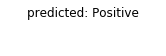

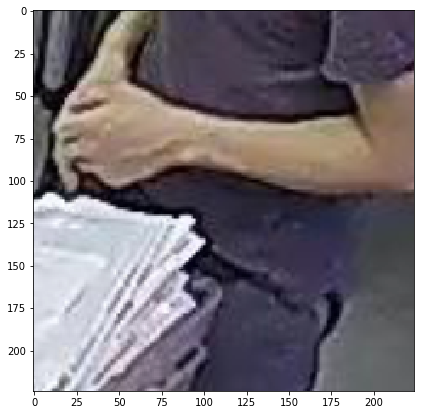

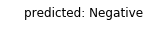

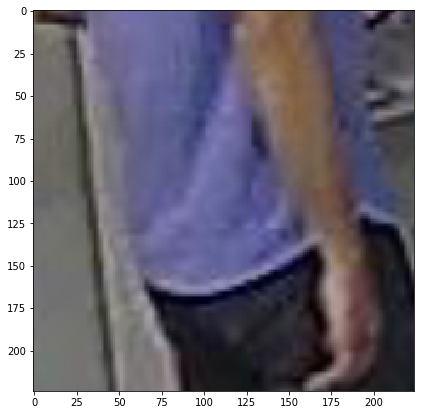

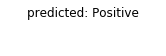

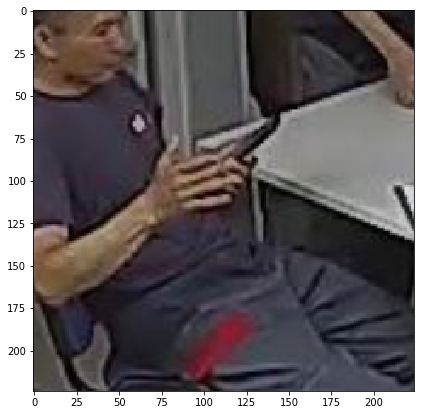

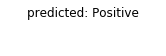

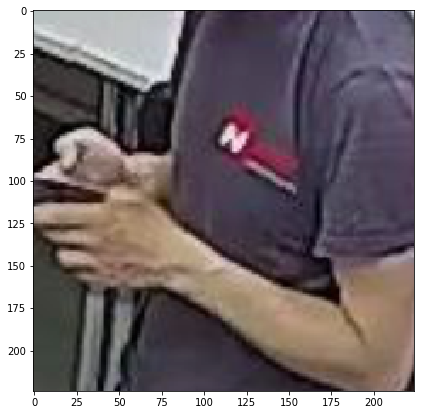

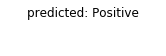

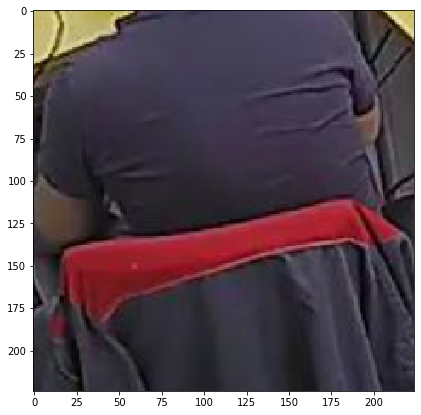

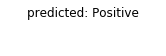

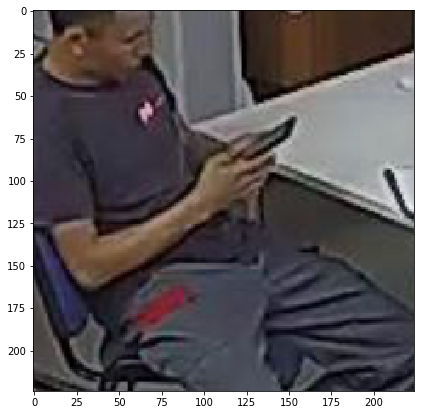

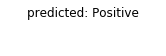

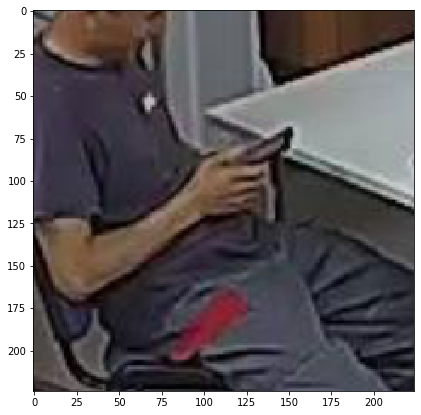

In [20]:
a1 = visualize_model(model_ft[0], 'validation', 14)

### Saving_part

In [21]:
Path_model_wts = os.getcwd() + '/model_resnet50_P1_0723_1.pt'

In [22]:
torch.save(model_ft[0].state_dict(), Path_model_wts)

In [23]:
torch.save(model_ft[0], Path_model_wts[:-4]+'_full.pt')

### Loading_part

In [ ]:
def visualize_model_cpu(model, data_set = 'test', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[data_set]):
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

            outputs = model(inputs)
            smth, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    return smth, preds

In [ ]:
Path_model_wts = 'C:\\Users\\Gleb\\Documents\\Data science\\Transfer learning\\model1.pt'

model.load_state_dict(torch.load(Path_model_wts))
model.eval()